In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
from scipy import stats
from cmdstanpy import CmdStanModel
import arviz as az

from config import DATABASE_URI

plt.rcParams["figure.figsize"] = (15,10)

In [3]:
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT date, close FROM prices WHERE frequency='MINUTE' AND ticker='^GSPC'")
        result = cur.fetchall()
    
data = pd.DataFrame.from_records(result, columns=["date", "close"], coerce_float=True, index="date").squeeze()

results_RV = {}
results_BV = {}
results_QV = {}
for idx, day in data.groupby(data.index.date):
    returns = np.log(day) - np.log(day.shift(1))
    results_RV[idx] = np.sum(np.square(returns))
    results_BV[idx] = (np.pi/2) * np.sum(np.abs(returns) * np.abs(returns.shift(1)))
    results_QV[idx] = 390 * np.sum(np.abs(returns) * np.abs(returns.shift(1)) * np.abs(returns.shift(2)) * np.abs(returns.shift(3)))

# Realized variance
RV = pd.Series(results_RV)
RV = RV.reindex(pd.to_datetime(RV.index))
# Bipower variation
BV = pd.Series(results_BV)
BV = BV.reindex(pd.to_datetime(BV.index))
# Quadpower variation
QV = pd.Series(results_QV)
QV = QV.reindex(pd.to_datetime(QV.index))
# Jump test statistic
theta = (np.square(np.pi)/4) + np.pi - 5
J = (np.sqrt(390) / np.sqrt(theta * np.maximum(1, QV / np.square(BV)))) * ((BV/RV) - 1)
# Boolean array of jump presence
jumps = J <= stats.norm.ppf(0.01)
# Magnitude of jumps on jump days = RV - BV
jumps_mag = ((RV - BV) * jumps)
# Continuous component of realized variance. On non-jump days it's equal to realized variance,
# on jump days it's equal to the bipower variation
RV_cont = ~jumps * RV + jumps * BV

In [148]:
x = pd.DataFrame(index=RV.index)
x["RCV"] = np.log(RV_cont)
x["RCV_5"] = np.log(RV_cont.rolling(5).mean())
x["RCV_21"] = np.log(RV_cont.rolling(21).mean())
# Log when not 0, otherwise 0
x["J"] = np.where(jumps_mag != 0, np.log(jumps_mag), 0)
x["J_5"] = np.where(jumps_mag.rolling(5).mean() != 0, np.log(jumps_mag.rolling(5).mean()), 0)
x["J_21"] = np.where(jumps_mag.rolling(21).mean() != 0, np.log(jumps_mag.rolling(21).mean()), 0)
x = x.dropna()

y = np.log(RV.shift(-1).dropna())

common_index = x.index.intersection(y.index)
split = int(0.75 * len(common_index))
x_train = x.loc[common_index[:split]]
x_test = x.loc[common_index[split:]]
j_train = jumps.loc[common_index[:split]]
j_test = jumps.loc[common_index[split:]]
y_train = y.loc[common_index[:split]]
y_test = y.loc[common_index[split:]]

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
# Get time indexes of where jumps occured
jump_indexes = np.arange(0, len(jumps))[jumps]
# number of days between jumps
jump_intervals = np.diff(jump_indexes)

In [80]:
model_spec = """
data {
    int N;  // Length of data
    int M;  // Number of features
    vector[N] y;  // Forecast objective
    matrix[N, M] x;  // Features matrix
    vector[N] j;  // Boolean vector of jump occurences
}
parameters {
    // Hawkes process parameters
    real mu_p;
    vector[3] gamma;
    real beta_p;
    real alpha_p;
    
    // Regression parameters
    real mu;
    vector[M] beta;
    real<lower=0> sigma;
    real theta;
}
transformed parameters {
    vector[N] lambda;
    lambda[1] = mu_p;
    for (t in 2:N) {
        lambda[t] = mu_p + dot_product(gamma, x[t, 1:3]) + beta_p * lambda[t-1] + alpha_p * j[t-1];
    }
}
model {
    mu_p ~ normal(0, 1);
    gamma ~ normal(0, 5);
    beta_p ~ normal(0, 1);
    alpha_p ~ normal(0, 1);
    mu ~ normal(0, 5);
    beta ~ normal(0, 5);
    sigma ~ normal(0, 10);
    theta ~ normal(0, 1);
    
    y ~ normal(mu + x * beta + theta * lambda, sigma);
}
"""

In [163]:
with open("./stan_model/RV_model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/RV_model.stan")
data = {
    "N": len(x_train),
    "M": len(x_train.columns),
    "y": y_train.values,
    "x": x_train.values,
    "j": j_train.astype(int).values
}
sample = model.sample(data=data,
                      chains=4,
                      parallel_chains=4,
                      iter_warmup=250,
                      iter_sampling=250,
                      inits=0,
                      max_treedepth=12,
                      adapt_delta=0.9)

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


In [165]:
sample.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpelg34abh/RV_model-202201170011-1-phool06f.csv, /tmp/tmpelg34abh/RV_model-202201170011-2-jpzv7ujc.csv, /tmp/tmpelg34abh/RV_model-202201170011-3-ddunz37m.csv, /tmp/tmpelg34abh/RV_model-202201170011-4-rcyesj8y.csv

Checking sampler transitions treedepth.
7 of 1000 (0.7%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
63 of 1000 (6.3%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had sp

"Processing csv files: /tmp/tmpelg34abh/RV_model-202201170011-1-phool06f.csv, /tmp/tmpelg34abh/RV_model-202201170011-2-jpzv7ujc.csv, /tmp/tmpelg34abh/RV_model-202201170011-3-ddunz37m.csv, /tmp/tmpelg34abh/RV_model-202201170011-4-rcyesj8y.csv\n\nChecking sampler transitions treedepth.\n7 of 1000 (0.7%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n63 of 1000 (6.3%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nThe following parameters ha

In [166]:
model_data = az.from_cmdstanpy(posterior=sample)

array([[<AxesSubplot:title={'center':'mu_p'}>,
        <AxesSubplot:title={'center':'mu_p'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'beta_p'}>,
        <AxesSubplot:title={'center':'beta_p'}>],
       [<AxesSubplot:title={'center':'alpha_p'}>,
        <AxesSubplot:title={'center':'alpha_p'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

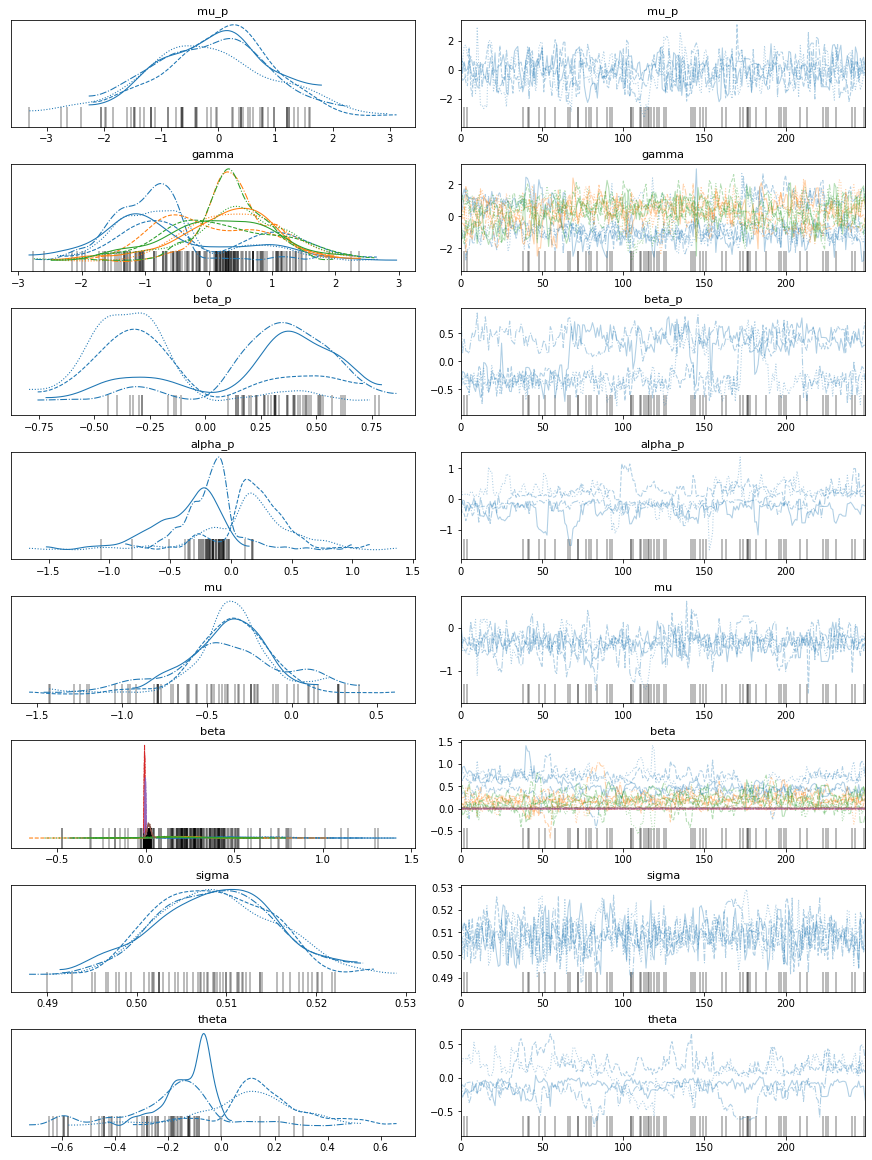

In [167]:
az.plot_trace(model_data, compact=True, var_names=["mu_p", "gamma", "beta_p", "alpha_p", "mu", "beta", "sigma", "theta"])